<a href="https://colab.research.google.com/github/An210/ML/blob/main/LSTM_Crypto%20Grid%20Search%20%26%20Model%20Selection%20Linear%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Install necessary packages
!pip install cryptocompare seaborn scikit-learn scikeras statsmodels

# Set TensorFlow to reduce logging
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier,
                              ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Input
from scikeras.wrappers import KerasRegressor
import cryptocompare
!pip install tensorflow
import tensorflow as tf
import pdb

# Data Loading & Feature Learning

In [2]:


def get_historical_price_data(period=360):
    # Get the current timestamp
    end_time = datetime.now()

    # Calculate the start time (30 days ago)
    start_time = end_time - timedelta(days=period)

    # Convert timestamps to Unix timestamps
    end_timestamp = int(end_time.timestamp())
    start_timestamp = int(start_time.timestamp())

    # Get historical price data
    price_data = cryptocompare.get_historical_price_day(
        'ETH', 'USD', limit=period, toTs=end_timestamp, exchange='CCCAGG'
    )

    # Create a Pandas DataFrame
    df = pd.DataFrame(price_data)

    # Convert 'time' column to datetime objects
    df['time'] = pd.to_datetime(df['time'], unit='s')

    # Rename columns to match your desired format
    df = df.rename(
        columns={
            'time': 'Timestamp',
            'high': 'High',
            'low': 'Low',
            'open': 'Open',
            'volumefrom': 'VolumeFrom',
            'volumeto': 'VolumeTo',
            'close': 'Close',
        }
    )

    return df

# Get historical price data
historical_data = get_historical_price_data()
historical_data = historical_data.drop(['conversionType', 'conversionSymbol'], axis=1)

# Print the DataFrame
print(historical_data.sort_values(by='Timestamp', ascending=False))

     Timestamp     High      Low     Open  VolumeFrom      VolumeTo    Close
360 2024-12-13  3969.42  3854.19  3882.65   664037.40  2.599313e+09  3906.64
359 2024-12-12  3989.26  3800.06  3834.97   992205.50  3.885861e+09  3882.65
358 2024-12-11  3851.87  3564.93  3630.62   846033.64  3.159617e+09  3834.97
357 2024-12-10  3782.03  3516.11  3714.19  1532770.64  5.597783e+09  3630.62
356 2024-12-09  4008.95  3518.41  4007.11  1331815.99  5.064826e+09  3714.19
..         ...      ...      ...      ...         ...           ...      ...
4   2023-12-23  2332.23  2267.35  2326.53   192582.36  4.418235e+08  2309.54
3   2023-12-22  2343.73  2231.32  2239.88   393077.37  9.041081e+08  2326.53
2   2023-12-21  2279.10  2183.31  2202.03   315319.45  7.021664e+08  2239.88
1   2023-12-20  2265.11  2157.77  2177.38   361405.83  7.995999e+08  2202.03
0   2023-12-19  2253.93  2135.19  2218.75   285016.52  6.278577e+08  2177.38

[361 rows x 7 columns]


In [3]:
X = historical_data.copy()
y = X.pop("Close")
X['Timestamp'] = pd.to_datetime(X['Timestamp']).astype('int64') // 10**9

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Verify integer types and correct them if needed
X = X.apply(lambda x: pd.to_numeric(x, downcast='integer'))

# Check for discrete features
discrete_features = X.dtypes == 'int'

# Define function for MI scores
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Calculate MI scores
mi_scores = make_mi_scores(X, y, discrete_features)
print("\nSelected MI Scores:\n", mi_scores[::1])





Selected MI Scores:
 High          2.249049
Low           2.160984
Open          1.618625
Timestamp     1.456157
VolumeTo      0.124880
VolumeFrom    0.113468
Name: MI Scores, dtype: float64


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:378: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


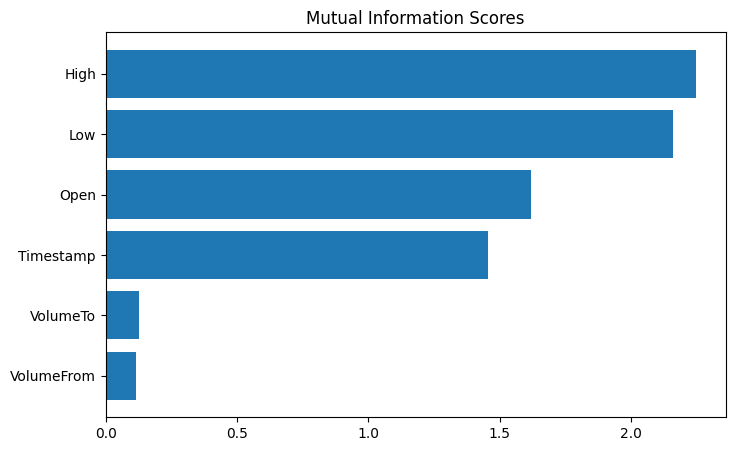

In [4]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

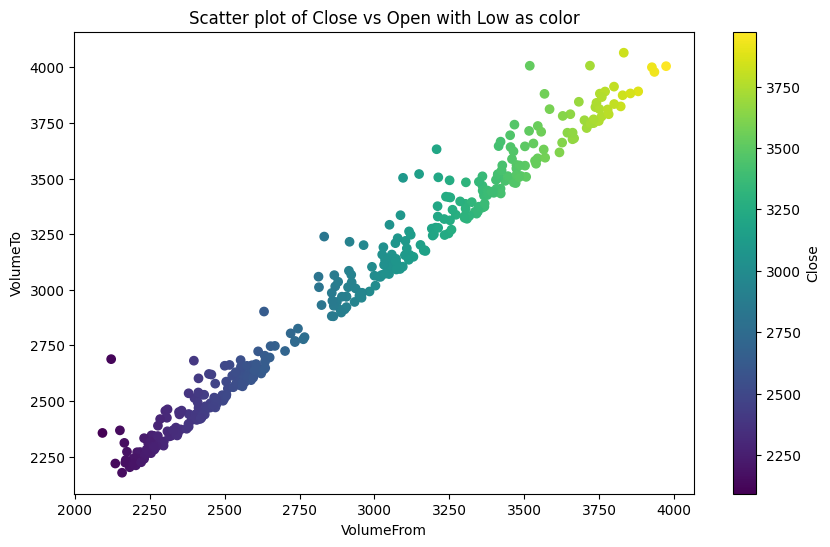

In [5]:

plt.figure(figsize=(10, 6))
scatter = plt.scatter(historical_data["Low"], historical_data["Open"], c=historical_data["Low"], cmap="viridis")
plt.colorbar(scatter, label="Close")
plt.xlabel("VolumeFrom")
plt.ylabel("VolumeTo")
plt.title("Scatter plot of Close vs Open with Low as color")
plt.show()

# Data processing & model creation/training

In [6]:


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(historical_data[['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length + 1])
    return np.array(sequences)

seq_length = 10  # You can adjust this based on your data
sequences = create_sequences(scaled_data, seq_length)

# Split into features (X) and target (y)
X = sequences[:, :-1]
y = sequences[:, -1, -1]  # We are predicting the 'Close' price
# Split into training and validation sets
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [14]:


# Custom wrapper for statsmodels forecasting models
class StatsForecastWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_type='SES', smoothing_level=None,
                 seasonal_periods=None, trend=None, seasonal=None,
                 damped_trend=False, initialization_method='estimated',  # Keep for other models
                 order=None, measurement_error=False):
        self.model_type = model_type
        self.smoothing_level = smoothing_level
        self.seasonal_periods = seasonal_periods
        self.trend = trend
        self.seasonal = seasonal
        self.damped_trend = damped_trend
        self.initialization_method = initialization_method
        self.order = order
        self.measurement_error = measurement_error
        self.model = None

    def fit(self, X, y):
        if self.model_type == 'SES':
            self.model = SimpleExpSmoothing(y)
            self.fitted_model = self.model.fit(
                smoothing_level=self.smoothing_level
                # initialization_method=self.initialization_method
            )
        elif self.model_type == 'HWES':
            self.model = ExponentialSmoothing(
                y,
                seasonal_periods=self.seasonal_periods,
                trend=self.trend,
                seasonal=self.seasonal,
                damped_trend=self.damped_trend
            )
            self.fitted_model = self.model.fit()
        elif self.model_type == 'VARMAX':
            self.model = VARMAX(
                X,
                order=self.order,
                measurement_error=self.measurement_error
            )
            self.fitted_model = self.model.fit()

        return self

    def predict(self, X):
        if self.model_type == 'VARMAX':
            return self.fitted_model.forecast(steps=len(X))
        else:
            return self.fitted_model.forecast(len(X))

def create_model(lstm_units=100, dropout_rate=0.3, learning_rate=0.0005):
    model = Sequential()
    model.add(Input(shape=(seq_length, 6)))

    # First LSTM layer
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
    model.add(Dropout(dropout_rate))

    # Second LSTM layer
    model.add(Bidirectional(LSTM(lstm_units // 2)))
    model.add(Dropout(dropout_rate))

    # Dense layers
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile with optimizer
    optimizer = keras.optimizers.Adam(
        learning_rate=learning_rate,
        clipnorm=1.0  # Add gradient clipping
    )

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        jit_compile=True  # Enable XLA compilation
    )

    return model

# Create a KerasRegressor for the LSTM model
lstm_model = KerasRegressor(
    model=create_model,
    lstm_units=100,
    dropout_rate=0.3,
    learning_rate=0.0005,
    verbose=0
)

# Initialize the models with correct parameters
ses_model = StatsForecastWrapper(
    model_type='SES',
    smoothing_level=0.3,
    initialization_method='estimated'
)

hwes_model = StatsForecastWrapper(
    model_type='HWES',
    seasonal_periods=12,
    trend='add',
    seasonal='add',
    damped_trend=False,
    initialization_method='estimated'
)

varmax_model = StatsForecastWrapper(
    model_type='VARMAX',
    order=(1, 1),
    measurement_error=False
)

# Update the models dictionary
models = {
    # 'LSTM': lstm_model,
    # 'SES': ses_model,
    # 'HWES': hwes_model,
    # 'RandomForestRegressor': RandomForestRegressor(random_state=0),
    'VARMAX': varmax_model

}

# Update the model parameters grid
model_grid_params = {
    # 'LSTM': {
    #     'model__lstm_units': [50, 100, 150],
    #     'model__dropout_rate': [0.2, 0.3, 0.4],
    #     'model__learning_rate': [0.001, 0.0005, 0.0001],
    #     'batch_size': [16, 32, 64],
    #     'epochs': [2, 2, 2]
    # },
    # 'RandomForestRegressor': {
    #     'n_estimators': [100, 200],
    #     'max_depth': [None, 10, 20],
    #     'min_samples_split': [2, 5, 10]
    # },
    # 'SES': {
    #     'smoothing_level': [0.1, 0.3, 0.7, None],
    #     'initialization_method': ['estimated']
    # },
    # 'HWES': {
    #     'seasonal_periods': [12],
    #     'trend': ['add', 'mul'],
    #     'seasonal': ['add', 'mul'],
    #     'damped_trend': [True, False],
    #     'initialization_method': ['estimated']
    # }
    # ,
    'VARMAX': {
        'order': [(1, 1), (2, 1), (1, 2)],
        'measurement_error': [True, False]
    }
}

# Create TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

best_models = {}

# Configure TensorFlow for better performance
tf.config.run_functions_eagerly(False)
tf.config.optimizer.set_jit(True)  # Enable XLA

for model_name, model in models.items():
    print(f"Performing Grid Search for {model_name}...")

    param_grid = model_grid_params.get(model_name, {})

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=1,  # Important for TF models
        error_score='raise'
    )

    if model_name in ['LSTM']:
        # Ensure X is a numpy array with the correct shape
        X_reshaped = np.asarray(X, dtype=np.float32)
        if len(X_reshaped.shape) == 2:
            X_reshaped = X_reshaped.reshape(X_reshaped.shape[0], seq_length, -1)
    elif model_name in ['SES', 'HWES']:
        # These models expect 1D input
        X_reshaped = y  # Use only the target variable
    else:
        X_reshaped = X.reshape(X.shape[0], -1)

    print(model_name)
    try:
        print(X_reshaped.shape)
        grid_result = grid.fit(X_reshaped, y)
        print(f"Best parameters for {model_name}: {grid_result.best_params_}")
        print(f"Best score for {model_name}: {grid_result.best_score_}")
        best_models[model_name] = grid_result.best_estimator_
    except Exception as e:
        print(f"Error during grid search for {model_name}: {str(e)}")
        continue

Performing Grid Search for VARMAX...
VARMAX
(351, 60)
Error during grid search for VARMAX: array must not contain infs or NaNs
Performing Grid Search for RandomForestRegressor...
RandomForestRegressor
(351, 60)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:395: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'


Best parameters for RandomForestRegressor: {}
Best score for RandomForestRegressor: -0.014069167748334254


# Testing model for predicting future values






In [ ]:
# Number of days to predict ahead
num_days_ahead = 20

# Get the last 'seq_length' data points from historical_data
current_sequence = scaled_data[-seq_length:]
predictions = []
timestamps = []
trade_timestamps = []  # Initialize trade_timestamps as a list

# Loop to predict for the next 'num_days_ahead' days
for i in range(num_days_ahead):
    # Reshape the current sequence to match the model's input shape
    current_sequence = current_sequence.reshape((1, seq_length, scaled_data.shape[1]))

    # Make prediction for the next day
    prediction = model.predict(current_sequence)

    # Inverse transform prediction to get actual price
    prediction = scaler.inverse_transform(np.concatenate((np.zeros((prediction.shape[0], scaled_data.shape[1] - 1)), prediction), axis=1))[:, -1]

    # Reshape the prediction to match the dimensions of current_sequence
    prediction_reshaped = np.repeat(prediction[:, np.newaxis], scaled_data.shape[1], axis=1)
    prediction_reshaped = prediction_reshaped.reshape(1, 1, scaled_data.shape[1])

    #Create a temporary DataFrame for scaling
    temp_df = pd.DataFrame(prediction_reshaped.reshape(1, -1), columns=['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close'])

    #Scale using the temporary DataFrame
    prediction_scaled = scaler.transform(temp_df).reshape(1, 1, scaled_data.shape[1])

    # Get the timestamp for the prediction
    timestamp = historical_data['Timestamp'].iloc[-1] + pd.Timedelta(days=i + 1)  # Add i+1 days to the last timestamp

    # Print prediction with timestamp
    print(f"Predicted Ethereum price for {timestamp}: {prediction[0]}")
    predictions.append(prediction[0])
    timestamps.append(timestamp)
    # Update the current sequence for the next prediction
    current_sequence = np.append(current_sequence[:, 1:, :], prediction_scaled, axis=1)  # Append the prediction to the sequence and remove the first element

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(historical_data['Timestamp']), historical_data['Close'], label='Original Close Price', marker='o')
plt.plot(timestamps, predictions, label='Predicted Close Price', marker='x', linestyle='--')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('Ethereum Close Price Prediction')
plt.legend()
plt.grid(True)
plt.show()

# Run model's back testing

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


backtest_start_date = '2024-01-01'  # Adjust this to your desired start date
backtest_end_date = '2024-11-15'  # Adjust this to your desired end date

# Filter historical data for the backtesting period
backtest_data = historical_data[(historical_data['Timestamp'] >= backtest_start_date) & (historical_data['Timestamp'] <= backtest_end_date)]

# Prepare backtesting data
scaled_backtest_data = scaler.transform(backtest_data[['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close']])
backtest_sequences = create_sequences(scaled_backtest_data, seq_length)
X_backtest = backtest_sequences[:, :-1]
y_backtest = backtest_sequences[:, -1, -1]  # We are predicting the 'Close' price

# Make predictions on the backtesting data
backtest_predictions = model.predict(X_backtest)

# Inverse transform the predictions to get the actual close prices
backtest_predictions = scaler.inverse_transform(np.concatenate((np.zeros((backtest_predictions.shape[0], X_backtest.shape[2] - 1)), backtest_predictions), axis=1))[:, -1]

# Evaluate backtesting performance
rmse = np.sqrt(mean_squared_error(backtest_data['Close'].iloc[seq_length:], backtest_predictions))
r2 = r2_score(backtest_data['Close'].iloc[seq_length:], backtest_predictions)
mape = mean_absolute_percentage_error(backtest_data['Close'].iloc[seq_length:], backtest_predictions)

print(f'Backtesting RMSE: {rmse}')
print(f'Backtesting R-squared: {r2}')
print(f'Backtesting MAPE: {mape}')

# Plotting the backtesting results
plt.figure(figsize=(12, 6))
plt.plot(backtest_data['Timestamp'].iloc[seq_length:], backtest_data['Close'].iloc[seq_length:], label='Actual', color='blue')
plt.plot(backtest_data['Timestamp'].iloc[seq_length:], backtest_predictions, label='Predicted', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Ethereum Price')
plt.title('Ethereum Price Backtesting')
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative profit/loss and trading submissions

In [ ]:


def run_backtest(backtest_predictions, backtest_data, seq_length, initial_budget=10000,
                 position_size=0.2, min_trade_amount=10):
    """
    Run backtest with support for partial units trading

    Parameters:
    -----------
    backtest_predictions : array-like
        Model predictions for buy/sell signals
    backtest_data : pandas.DataFrame
        Historical price data with 'Close' column
    seq_length : int
        Sequence length used in the model
    initial_budget : float
        Starting budget for trading
    position_size : float
        Percentage of budget to use per trade (0.0 to 1.0)
    min_trade_amount : float
        Minimum amount in currency units for a trade

    Returns:
    --------
    dict
        Dictionary containing backtest results and metrics
    """
    profit_loss_backtest = []
    trades = []
    current_budget = initial_budget
    current_holdings = 0  # Amount of coins/shares held

    # Trading metrics
    num_trades = 0
    winning_trades = 0
    losing_trades = 0

    # Ensure proper length for backtesting
    test_length = min(len(backtest_predictions), len(backtest_data))

    for i in range(1, test_length):
        current_price = backtest_data['Close'].iloc[i - 1 + seq_length]
        next_price = backtest_data['Close'].iloc[i + seq_length]

        # Calculate trade size based on position sizing
        max_trade_amount = current_budget * position_size

        if backtest_predictions[i - 1] > current_price:  # Buy signal
            if current_budget >= min_trade_amount:
                # Calculate amount to buy
                trade_amount = min(max_trade_amount, current_budget)
                coins_to_buy = trade_amount / current_price

                # Execute buy
                current_holdings += coins_to_buy
                current_budget -= trade_amount

                trades.append({
                    'type': 'buy',
                    'price': current_price,
                    'amount': coins_to_buy,
                    'value': trade_amount,
                    'timestamp': backtest_data['Timestamp'].iloc[i - 1 + seq_length]
                })

                profit_loss_backtest.append(0)  # No immediate P/L on buy
                num_trades += 1
            else:
                profit_loss_backtest.append(0)

        else:  # Sell signal
            if current_holdings > 0:
                # Calculate sell value
                sell_value = current_holdings * current_price
                profit_loss = current_holdings * (current_price - trades[-1]['price'])

                # Track trade outcome
                if profit_loss > 0:
                    winning_trades += 1
                elif profit_loss < 0:
                    losing_trades += 1

                # Execute sell
                current_budget += sell_value
                profit_loss_backtest.append(profit_loss)

                trades.append({
                    'type': 'sell',
                    'price': current_price,
                    'amount': current_holdings,
                    'value': sell_value,
                    'profit_loss': profit_loss,
                    'timestamp': backtest_data['Timestamp'].iloc[i - 1 + seq_length]
                })

                current_holdings = 0
                num_trades += 1
            else:
                profit_loss_backtest.append(0)

    # Calculate final metrics
    cumulative_profit_loss = sum(profit_loss_backtest)
    win_rate = winning_trades / num_trades if num_trades > 0 else 0

    # Calculate current portfolio value (cash + holdings)
    final_holding_value = current_holdings * backtest_data['Close'].iloc[-1]
    total_portfolio_value = current_budget + final_holding_value

    # Calculate return metrics
    total_return = (total_portfolio_value - initial_budget) / initial_budget * 100

    return {
        'trades': trades,
        'profit_loss_history': profit_loss_backtest,
        'cumulative_profit_loss': cumulative_profit_loss,
        'final_budget': current_budget,
        'final_holdings': current_holdings,
        'final_portfolio_value': total_portfolio_value,
        'total_return_pct': total_return,
        'num_trades': num_trades,
        'win_rate': win_rate,
        'metrics': {
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'win_rate': win_rate
        }
    }

def plot_backtest_results(backtest_results, backtest_data):
    """
    Plot backtest results including portfolio value and trade points
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot 1: Cumulative Profit/Loss
    cumulative_pl = np.cumsum(backtest_results['profit_loss_history'])
    # Fix: Generate trade_timestamps based on the length of cumulative_pl
    # to ensure they have the same dimension.
    trade_timestamps = backtest_data['Timestamp'].iloc[seq_length:seq_length + len(cumulative_pl)].values

    ax1.plot(trade_timestamps, cumulative_pl)
    ax1.set_title('Cumulative Profit/Loss Over Time')
    ax1.set_xlabel('Date')  # Changed x-axis label for clarity
    ax1.set_ylabel('Profit/Loss')
    ax1.grid(True)

     # Plot 2: Price with Buy/Sell points
    ax2.plot(backtest_data['Timestamp'].iloc[seq_length:], backtest_data['Close'].iloc[seq_length:], label='Price', alpha=0.7)

    # Plot buy points
    buy_trades = [t for t in backtest_results['trades'] if t['type'] == 'buy']
    if buy_trades:
        buy_times = [t['timestamp'] for t in buy_trades]
        buy_prices = [t['price'] for t in buy_trades]
        ax2.scatter(buy_times, buy_prices, color='green', marker='^', label='Buy')

    # Plot sell points
    sell_trades = [t for t in backtest_results['trades'] if t['type'] == 'sell']
    if sell_trades:
        sell_times = [t['timestamp'] for t in sell_trades]
        sell_prices = [t['price'] for t in sell_trades]
        ax2.scatter(sell_times, sell_prices, color='red', marker='v', label='Sell')

    ax2.set_title('Price Chart with Trade Points')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:

# Run backtest
backtest_results = run_backtest(
    backtest_predictions,
    backtest_data,
    seq_length=seq_length,
    initial_budget=10000,
    position_size=1,  # Use 20% of budget per trade
    min_trade_amount=10
)

# Print results
print(f"Final Portfolio Value: ${backtest_results['final_portfolio_value']:.2f}")
print(f"Total Return: {backtest_results['total_return_pct']:.2f}%")
print(f"Number of Trades: {backtest_results['num_trades']}")
print(f"Win Rate: {backtest_results['win_rate']*100:.2f}%")

# Plot results
plot_backtest_results(backtest_results, backtest_data)


In [ ]:
print(backtest_data.index[i - 1 + seq_length])